In [1]:
# Bibliotecas
import pandas as pd
from pandas import json_normalize
import numpy as np
import io
import requests
import json
import datetime
import scipy.stats as stats
from datetime import datetime
import time

import os

import pyarrow

import matplotlib.pyplot as plt
import seaborn           as sns

In [4]:
class agro:
    
    def __init__(self, tickers: "list of tickers", init_date: "initial date",
                 end_date: "end date", index: int, climate_var: str,
                 state: str, shift: int):
        # Inicialmente passo as variáveis para uma self.
        self.tickers = tickers # lista com os nomes das ações
        self.init_date = init_date
        self.end_date = end_date
        self.index = index # índice que será usado
        self.climate_var = climate_var
        self.state = state
        self.shift = shift
        
    def plot_agro(self):

        clima = pd.read_parquet('.\\raw_data\\clima_Agro.parquet', engine='pyarrow')
        clima = clima.drop_duplicates(['SIGLA_UF', 'Date'])
        clima.reset_index(drop = True, inplace = True)
        clima = clima.rename(columns={'Date': 'time'})
        clima['time'] = pd.to_datetime(clima['time'], format='%Y-%m-%d')
        
        clima = clima[clima.SIGLA_UF == self.state]
        
        names = pd.read_csv('.\\raw_data\\portfolio.csv') # ler o arquivo em csv
        names = pd.Series(names.stock_id.values,index=names.ticker).to_dict()

        cod = []
        for i in self.tickers:
            i = '$'+i
            cod.append([value for key, value in names.items() if key == i][0])

        url = ('https://stocks.tradersclub.com.br/stockschart/v1/history_quotes?stock='
               + str(cod[0]) +'&group='+ '1d' + 
               '&start='+ self.init_date + '&end=' + self.end_date)

        # credenciais de acesso a API
        headers = {"Authorization": f"ml_prod:4a1fc619-1993-42f3-adf4-123c0a72b3ee"}

        response = requests.request(
                            "GET", 
                            url,
                            headers=headers)

        # O request tem como saída um dicionário
        json_dict= json.loads(response.text)

        # Aqui trasformo o dicionário em um pandas Dataframe
        ticker = pd.DataFrame.from_dict(json_dict["Quotes"])

        # Pego apenas duas colunas. A coluna de time com a data e coulna do índice de interesse.
        cols_to_keep = ['time', self.index]
        ticker = ticker[cols_to_keep]
        # renomeio a coluna colocando o nome da ação como sufixo
        ticker = ticker.rename(columns={self.index: self.tickers[0]})
        ticker['time'] = pd.to_datetime(ticker['time'], format='%Y-%m-%d', utc=True)
        ticker['time'] = ticker['time'].dt.strftime('%Y-%m-%d')
        ticker['time'] = pd.to_datetime(ticker['time'], format='%Y-%m-%d')
        
        full = pd.merge(ticker, clima, on='time', how='left')
        
        full[self.tickers[0]] = full[self.tickers[0]].shift(5)
        
        from sklearn.preprocessing import MinMaxScaler
        full[self.tickers[0]] = MinMaxScaler().fit_transform(np.array(full[self.tickers[0]]).reshape(-1,1))
        full[self.climate_var] = MinMaxScaler().fit_transform(np.array(full[self.climate_var]).reshape(-1,1))
        
        #plt.figure(figsize=(12,7))
        f, ax = plt.subplots(figsize=(12,7))
        ax.plot(full.time, full[self.climate_var], full.time, full[self.tickers[0]])
        plt.title('Estado de ' + self.state + ':' + ' shift = ' + str(self.shift), fontsize = 25)
        plt.xlabel('Dias', fontsize = 35)
        plt.xticks(fontsize = 20, rotation=35)
        plt.yticks(fontsize = 25)
        str_shift = 'shift = ' + str(self.shift)
        plt.legend([self.climate_var, self.tickers[0], str_shift], loc = 'upper right', fontsize=20)
        plt.grid(color='gray', linestyle='--')
        plt.ylim(0, 1.2)

        return ax
    

C:\Users\AURELI~1.PAI\AppData\Local\Temp/ipykernel_15840/856051914.py:10: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  apiagro.plot_agro()


<AxesSubplot:title={'center':'Estado de SP: shift = 7'}, xlabel='Dias'>

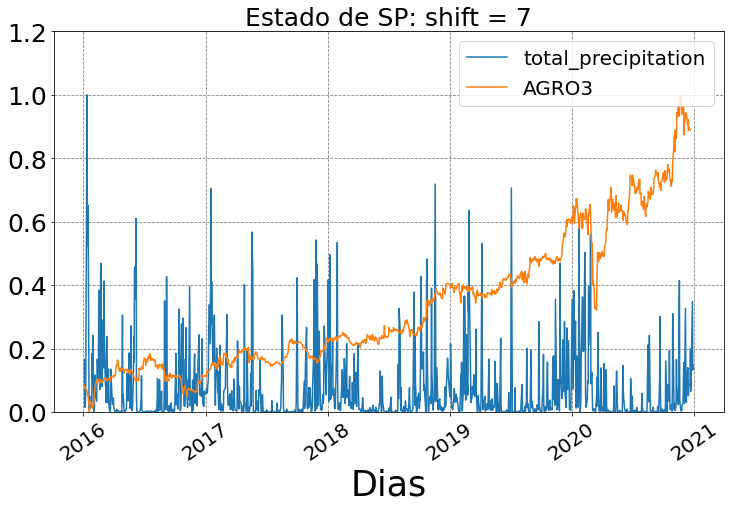

In [5]:
apiagro = agro(tickers = ['AGRO3'], # AGXY3, AGRO3, SOJA3, BRFS3, JBSS3
                     init_date = '2016-01-01', # '%Y-%m-%d'
                     end_date = '2020-12-31', # '%Y-%m-%d'
                     index = 'Close',
                     shift = 7,
                     climate_var = 'total_precipitation',
                     state = 'SP'
         ) 

apiagro.plot_agro()

C:\Users\AURELI~1.PAI\AppData\Local\Temp/ipykernel_15840/3378310526.py:10: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  apiagro.plot_agro()


<AxesSubplot:title={'center':'Estado de MG: shift = 15'}, xlabel='Dias'>

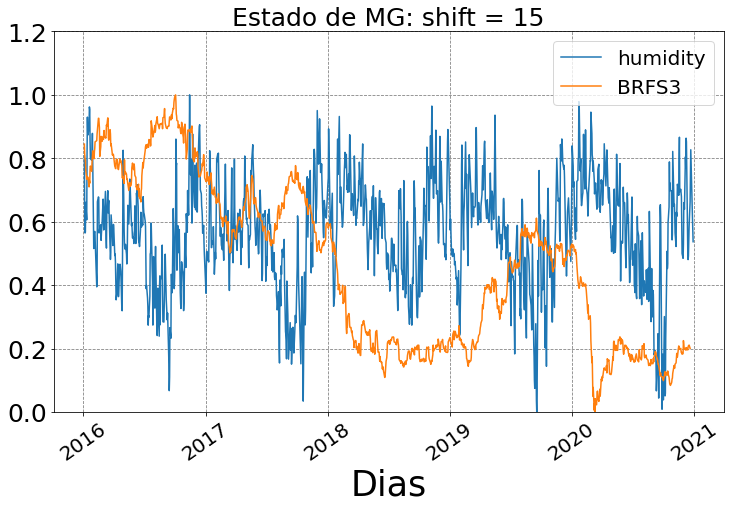

In [6]:
apiagro = agro(tickers = ['BRFS3'], # AGXY3, AGRO3, SOJA3, BRFS3, JBSS3
                     init_date = '2016-01-01', # '%Y-%m-%d'
                     end_date = '2020-12-31', # '%Y-%m-%d'
                     index = 'Close',
                     shift = 15,
                     climate_var = 'humidity',
                     state = 'MG'
         ) 

apiagro.plot_agro()

In [ ]:
apiagro = agro(tickers = ['JBSS3'], # AGXY3, AGRO3, SOJA3, BRFS3, JBSS3
                     init_date = '2016-01-01', # '%Y-%m-%d'
                     end_date = '2020-12-31', # '%Y-%m-%d'
                     index = 'Close',
                     shift = 30,
                     climate_var = 'temperature_2m',
                     state = 'GO'
         ) 

apiagro.plot_agro()

In [ ]:
apiagro = agro(tickers = ['JBSS3'], # AGXY3, AGRO3, SOJA3, BRFS3, JBSS3
                     init_date = '2016-01-01', # '%Y-%m-%d'
                     end_date = '2020-12-31', # '%Y-%m-%d'
                     index = 'Close',
                     shift = 60,
                     climate_var = 'temperature_2m',
                     state = 'GO'
         ) 

apiagro.plot_agro()